# DTD Dataset Classification Project

## Data Mining and Analysis - Complete Pipeline

This notebook implements:
1. **Data Preparation** (cleansing, transformation, 60-20-20 split)
2. **Exploratory Data Analysis (EDA)** (descriptive statistics, visualizations)
3. **Model Selection and Training** (Basic InceptionV3 trained from scratch)
4. **Model Evaluation** (metrics and confusion matrix)


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.manifold import TSNE
from collections import Counter
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries imported successfully!")


Using device: cuda
Libraries imported successfully!


## 1. Data Preparation

Load the DTD dataset from PyTorch and prepare train/validation/test splits.


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    """Custom dataset class for DTD with transforms"""
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

def prepare_data(data_dir='./data', batch_size=32, image_size=224, train_ratio=0.5, val_ratio=0.25, test_ratio=0.25):
    """
    Data Preparation:
    - Load DTD dataset from torchvision
    - Apply data transformations (cleansing and normalization)
    - Split into train (60%), validation (20%), and test (20%) sets
    """
    print("\n" + "="*60)
    print("1. DATA PREPARATION")
    print("="*60)
    
    # Basic data transformations for training
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load full DTD dataset (we'll split it ourselves)
    print("\nLoading DTD dataset...")
    # Load all splits and combine them
    full_dataset = datasets.DTD(root=data_dir, split='train', 
                                download=True, transform=None)
    
    # Get class names
    class_names = full_dataset.classes
    num_classes = len(class_names)
    
    # Load all available data (combine train, val, test splits)
    all_data = []
    for split in ['train', 'val', 'test']:
        split_dataset = datasets.DTD(root=data_dir, split=split, 
                                    download=True, transform=None)
        all_data.extend([(img, label) for img, label in split_dataset])
    
    # Create full dataset with no transform (we'll apply transforms in splits)
    full_custom_dataset = CustomDataset(all_data, transform=None)
    
    # Calculate split sizes
    total_size = len(full_custom_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size
    
    print(f"\nTotal samples: {total_size}")
    print(f"Train: {train_size} ({100*train_size/total_size:.1f}%)")
    print(f"Validation: {val_size} ({100*val_size/total_size:.1f}%)")
    print(f"Test: {test_size} ({100*test_size/total_size:.1f}%)")
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_custom_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Apply transforms to each split
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform
    
    # Create data loaders (num_workers=0 for Windows compatibility)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=0, pin_memory=False)
    
    print(f"Number of classes: {num_classes}")
    
    return train_loader, val_loader, test_loader, class_names, train_dataset, val_dataset, test_dataset

# Configuration
data_dir = './data'
results_dir = './results'
batch_size = 32
image_size = 224

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load data (60-20-20 split)
train_loader, val_loader, test_loader, class_names, train_dataset, val_dataset, test_dataset = \
    prepare_data(data_dir, batch_size, image_size, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)



1. DATA PREPARATION

Loading DTD dataset...

Total samples: 5640
Train: 3384 (60.0%)
Validation: 1128 (20.0%)
Test: 1128 (20.0%)
Number of classes: 47


## 2. Exploratory Data Analysis (EDA)

Perform descriptive statistics and visualizations.



2. EXPLORATORY DATA ANALYSIS (EDA)

2(a) Descriptive Statistics
----------------------------------------

Dataset Statistics:
  Total samples: 5640
  Training: 3384 (60.0%)
  Validation: 1128 (20.0%)
  Test: 1128 (20.0%)
  Number of classes: 47

Class Distribution Statistics:
  Mean samples per class (train): 72.0
  Std samples per class (train): 5.5
  Min samples per class (train): 57
  Max samples per class (train): 86

2(b) Data Visualization
----------------------------------------
  Saved: ./results/class_distribution.png


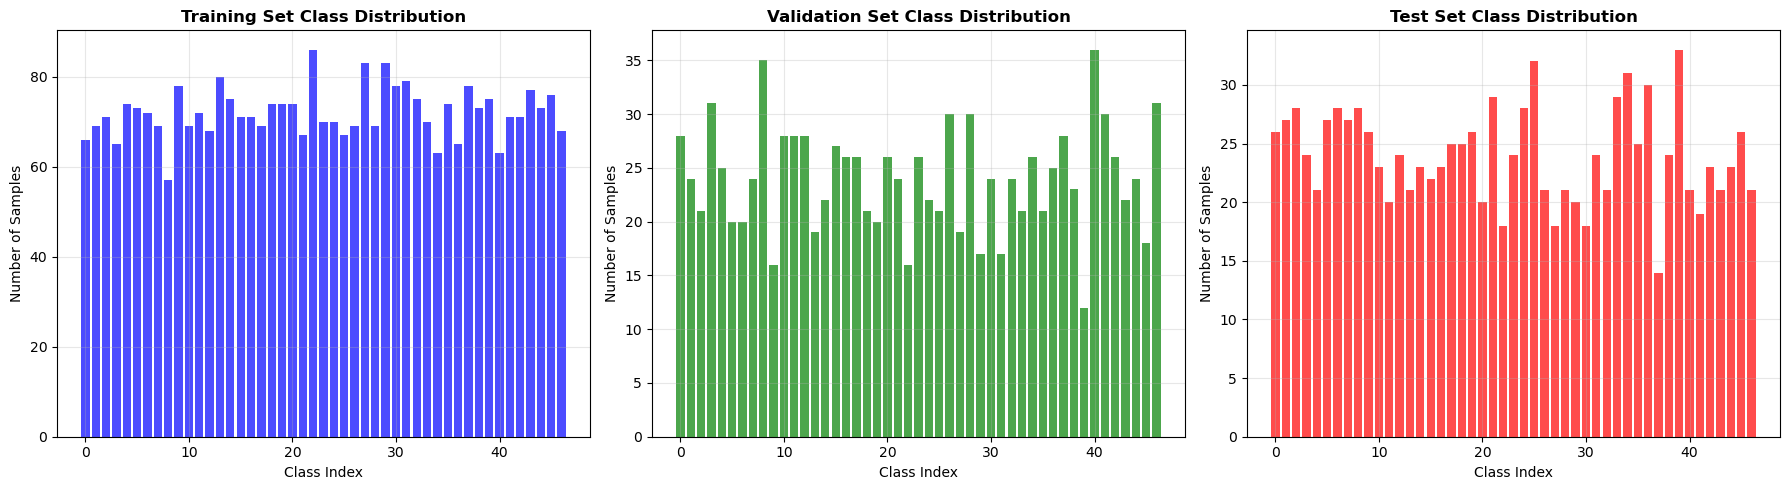

  Saved: ./results/example_images.png


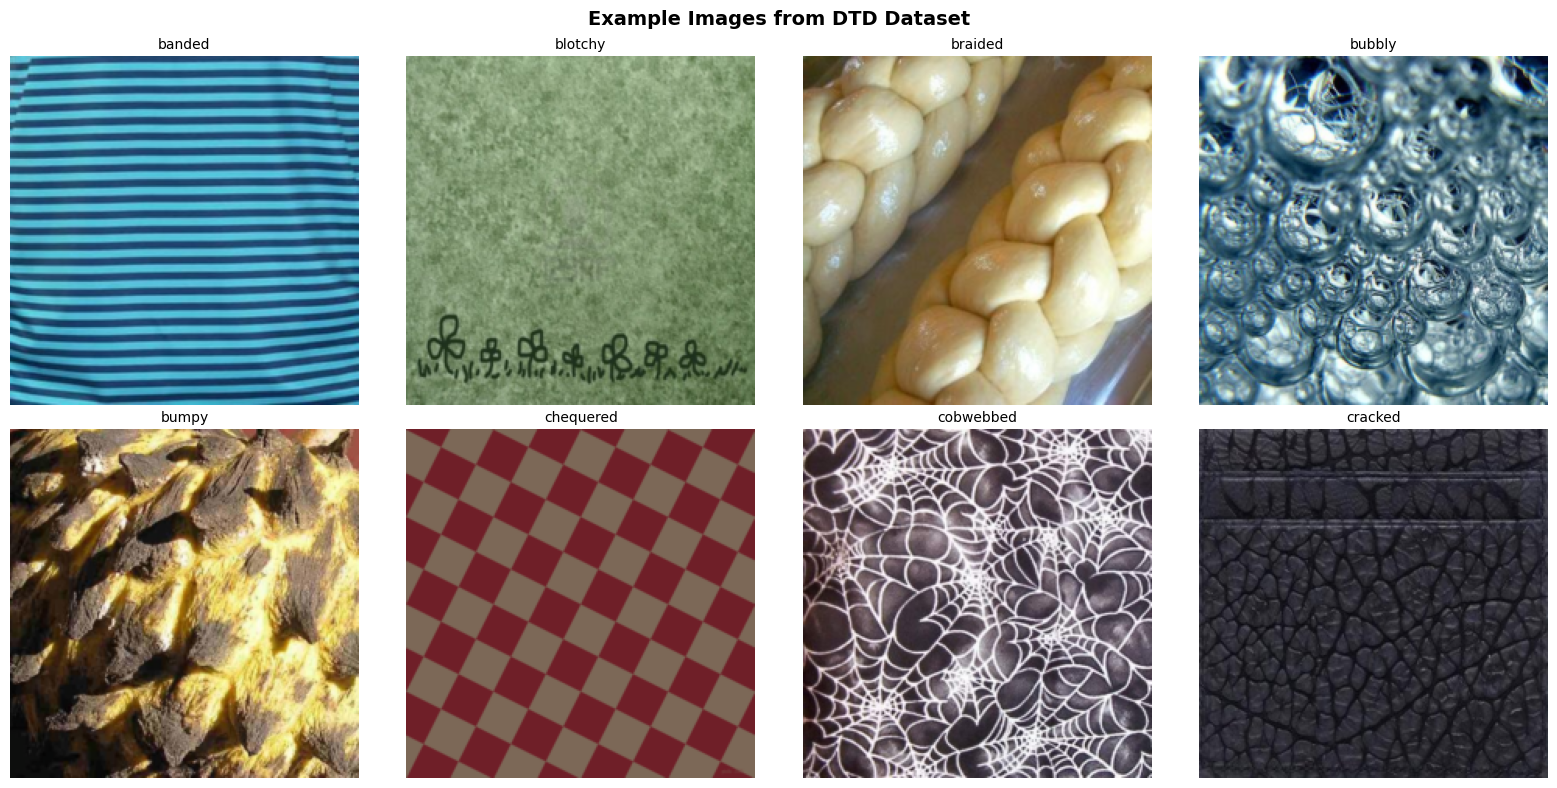


  Computing t-SNE visualization (this may take a while)...
  Saved: ./results/tsne_visualization.png


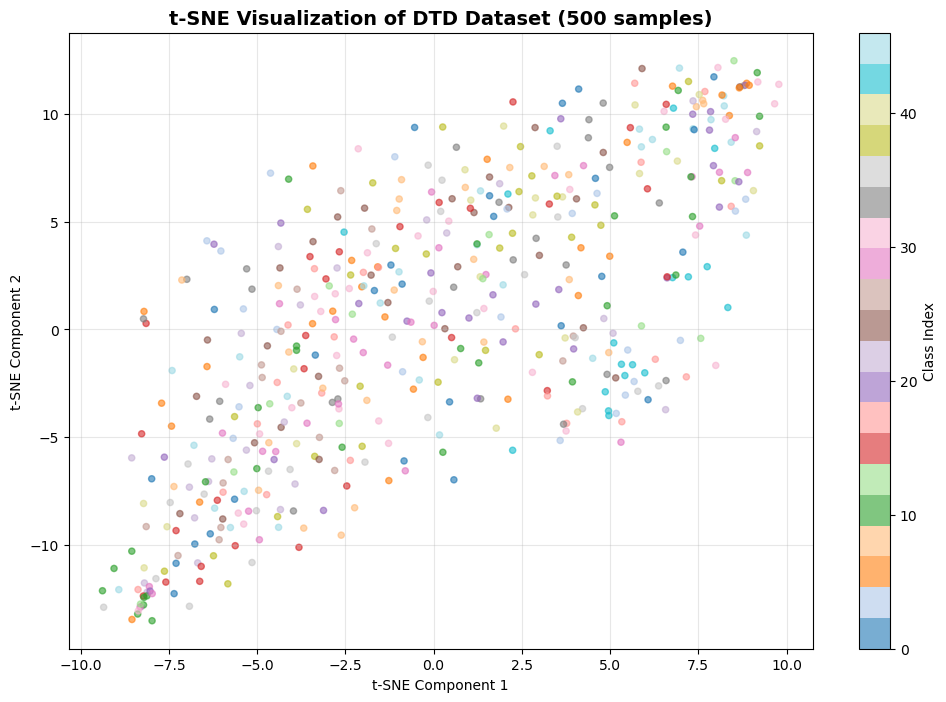


EDA completed!


In [3]:
def perform_eda(train_dataset, val_dataset, test_dataset, class_names, save_dir='./results'):
    """
    Exploratory Data Analysis:
    - Descriptive statistics (class distributions, data statistics)
    - Data visualization (example images, dimensionality reduction)
    """
    print("\n" + "="*60)
    print("2. EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*60)
    
    os.makedirs(save_dir, exist_ok=True)
    
    # 2(a) Descriptive Statistics
    print("\n2(a) Descriptive Statistics")
    print("-" * 40)
    
    # Count samples per class for each split
    def get_class_distribution(dataset):
        labels = []
        for i in range(len(dataset)):
            try:
                _, label = dataset[i]
                labels.append(label)
            except:
                continue
        return Counter(labels)
    
    train_dist = get_class_distribution(train_dataset)
    val_dist = get_class_distribution(val_dataset)
    test_dist = get_class_distribution(test_dataset)
    
    # Overall statistics
    total_train = len(train_dataset)
    total_val = len(val_dataset)
    total_test = len(test_dataset)
    total_samples = total_train + total_val + total_test
    
    print(f"\nDataset Statistics:")
    print(f"  Total samples: {total_samples}")
    print(f"  Training: {total_train} ({100*total_train/total_samples:.1f}%)")
    print(f"  Validation: {total_val} ({100*total_val/total_samples:.1f}%)")
    print(f"  Test: {total_test} ({100*total_test/total_samples:.1f}%)")
    print(f"  Number of classes: {len(class_names)}")
    
    # Class distribution statistics
    train_counts = [train_dist[i] for i in range(len(class_names))]
    val_counts = [val_dist[i] for i in range(len(class_names))]
    test_counts = [test_dist[i] for i in range(len(class_names))]
    
    print(f"\nClass Distribution Statistics:")
    print(f"  Mean samples per class (train): {np.mean(train_counts):.1f}")
    print(f"  Std samples per class (train): {np.std(train_counts):.1f}")
    print(f"  Min samples per class (train): {np.min(train_counts)}")
    print(f"  Max samples per class (train): {np.max(train_counts)}")
    
    # 2(b) Data Visualization
    print("\n2(b) Data Visualization")
    print("-" * 40)
    
    # Plot class distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].bar(range(len(class_names)), train_counts, alpha=0.7, color='blue')
    axes[0].set_title('Training Set Class Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Class Index')
    axes[0].set_ylabel('Number of Samples')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].bar(range(len(class_names)), val_counts, alpha=0.7, color='green')
    axes[1].set_title('Validation Set Class Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Class Index')
    axes[1].set_ylabel('Number of Samples')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].bar(range(len(class_names)), test_counts, alpha=0.7, color='red')
    axes[2].set_title('Test Set Class Distribution', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Class Index')
    axes[2].set_ylabel('Number of Samples')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/class_distribution.png', dpi=300, bbox_inches='tight')
    print(f"  Saved: {save_dir}/class_distribution.png")
    plt.show()
    
    # Plot example images from different classes
    num_examples = 8
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Get one example from each of the first 8 classes
    for class_idx in range(min(num_examples, len(class_names))):
        # Find an image from this class
        found = False
        for idx in range(len(train_dataset)):
            try:
                img, label = train_dataset[idx]
                if label == class_idx:
                    # Denormalize for visualization
                    img_np = img.numpy().transpose((1, 2, 0))
                    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img_np = np.clip(img_np, 0, 1)
                    
                    axes[class_idx].imshow(img_np)
                    axes[class_idx].set_title(f'{class_names[class_idx]}', fontsize=10)
                    axes[class_idx].axis('off')
                    found = True
                    break
            except:
                continue
        if not found:
            axes[class_idx].axis('off')
    
    plt.suptitle('Example Images from DTD Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/example_images.png', dpi=300, bbox_inches='tight')
    print(f"  Saved: {save_dir}/example_images.png")
    plt.show()
    
    # Dimensionality Reduction Visualization (t-SNE)
    print("\n  Computing t-SNE visualization (this may take a while)...")
    # Sample a subset for t-SNE (too many samples would be slow)
    sample_size = min(500, len(train_dataset))
    indices = np.random.choice(len(train_dataset), sample_size, replace=False)
    
    # Extract features using a simple CNN feature extractor
    sample_images = []
    sample_labels = []
    for idx in indices:
        try:
            img, label = train_dataset[idx]
            sample_images.append(img.numpy().flatten())
            sample_labels.append(label)
        except:
            continue
    
    sample_images = np.array(sample_images)
    sample_labels = np.array(sample_labels)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings = tsne.fit_transform(sample_images)
    
    # Plot t-SNE
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                         c=sample_labels, cmap='tab20', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Class Index')
    plt.title('t-SNE Visualization of DTD Dataset (500 samples)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{save_dir}/tsne_visualization.png', dpi=300, bbox_inches='tight')
    print(f"  Saved: {save_dir}/tsne_visualization.png")
    plt.show()
    
    print("\nEDA completed!")

# Run EDA
perform_eda(train_dataset, val_dataset, test_dataset, class_names, results_dir)


## 3. Model Selection and Training

Train basic InceptionV3 model from scratch (no pretrained weights).

### 3(a) Algorithm Selection Justification

**Selected Algorithm: InceptionV3 (Training from Scratch)**

**Justification:**
- **InceptionV3**: Multi-scale feature learning, efficient architecture
- **Training from scratch**: No pretrained weights, all layers trainable
- **Full model training**: All layers learn from the DTD dataset
- **Basic setup**: Standard data augmentation and training configuration


In [3]:
def create_model(num_classes):
    """
    Create basic InceptionV3 model from scratch (no pretrained weights)
    Train all layers from scratch
    """
    # Load InceptionV3 architecture without pretrained weights
    model = models.inception_v3(pretrained=False, aux_logits=True)
    # Disable aux_logits after loading
    model.aux_logits = False
    # Remove auxiliary classifier
    model.AuxLogits = None
    
    # All layers are trainable (training from scratch)
    for param in model.parameters():
        param.requires_grad = True
    
    # Replace final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, 
                model_name, save_dir='./results', patience=10):
    """
    Train a basic InceptionV3 model from scratch
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Basic optimizer with minimal weight decay
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=learning_rate, weight_decay=1e-4)
    # Simple learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    7
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print(f"\nTraining {model_name} for {num_epochs} epochs...")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: 1e-4")
    print(f"Early stopping patience: {patience} epochs")
    print(f"Training mode: From scratch (all layers trainable)")
    print(f"Trainable parameters: {sum(1 for p in model.parameters() if p.requires_grad)}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Update learning rate
        scheduler.step()
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, f'{save_dir}/{model_name.lower()}_best_model.pth')
            patience_counter = 0
            print(f'  ✓ New best validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'  No improvement. Patience: {patience_counter}/{patience}')
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(train_losses, label='Train Loss', color='blue')
    axes[0].plot(val_losses, label='Val Loss', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Training and Validation Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(train_accuracies, label='Train Acc', color='blue')
    axes[1].plot(val_accuracies, label='Val Acc', color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/{model_name.lower()}_training_curves.png', dpi=300, bbox_inches='tight')
    print(f"\n  Saved training curves: {save_dir}/{model_name.lower()}_training_curves.png")
    plt.show()
    
    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
    return model, best_val_acc

# Configuration
num_classes = len(class_names)
num_epochs = 50  # Standard number of epochs
learning_rate = 0.001  # Standard learning rate
patience = 10  # Early stopping patience

print("Model creation and training functions defined!")


Model creation and training functions defined!


### 3(b) Model Building and Training - InceptionV3



Training InceptionV3 Model

Training InceptionV3 for 50 epochs...
Learning rate: 0.001
Weight decay: 1e-4
Early stopping patience: 10 epochs
Training mode: From scratch (all layers trainable)
Trainable parameters: 284


Epoch 1/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=3.8500, acc=9.40%]



Epoch 1/50:
  Train Loss: 3.9125, Train Acc: 5.20%
  Val Loss: 3.9586, Val Acc: 9.40%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 9.40%


Epoch 2/50 [Val]: 100%|██████████| 36/36 [00:06<00:00,  5.14it/s, loss=3.5720, acc=9.93%] 



Epoch 2/50:
  Train Loss: 3.6531, Train Acc: 8.51%
  Val Loss: 3.5371, Val Acc: 9.93%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 9.93%


Epoch 3/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.65it/s, loss=3.1782, acc=13.39%]



Epoch 3/50:
  Train Loss: 3.5578, Train Acc: 9.37%
  Val Loss: 3.4769, Val Acc: 13.39%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 13.39%


Epoch 4/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s, loss=3.6525, acc=11.97%]



Epoch 4/50:
  Train Loss: 3.5146, Train Acc: 9.99%
  Val Loss: 3.8310, Val Acc: 11.97%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 5/50 [Val]: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s, loss=3.3477, acc=12.50%]



Epoch 5/50:
  Train Loss: 3.4743, Train Acc: 10.52%
  Val Loss: 3.4135, Val Acc: 12.50%
  Learning Rate: 0.001000
  No improvement. Patience: 2/10


Epoch 6/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s, loss=3.4570, acc=12.50%]



Epoch 6/50:
  Train Loss: 3.3869, Train Acc: 12.32%
  Val Loss: 3.4565, Val Acc: 12.50%
  Learning Rate: 0.001000
  No improvement. Patience: 3/10


Epoch 7/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s, loss=3.6078, acc=13.21%]



Epoch 7/50:
  Train Loss: 3.3060, Train Acc: 14.18%
  Val Loss: 3.6842, Val Acc: 13.21%
  Learning Rate: 0.001000
  No improvement. Patience: 4/10


Epoch 8/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s, loss=3.1523, acc=15.25%]



Epoch 8/50:
  Train Loss: 3.3257, Train Acc: 14.24%
  Val Loss: 3.3371, Val Acc: 15.25%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 15.25%


Epoch 9/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.65it/s, loss=3.2813, acc=13.92%]



Epoch 9/50:
  Train Loss: 3.2342, Train Acc: 15.57%
  Val Loss: 3.3082, Val Acc: 13.92%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 10/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s, loss=3.2921, acc=16.76%]



Epoch 10/50:
  Train Loss: 3.1828, Train Acc: 17.26%
  Val Loss: 3.3159, Val Acc: 16.76%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 16.76%


Epoch 11/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.66it/s, loss=3.5993, acc=16.93%]



Epoch 11/50:
  Train Loss: 3.1339, Train Acc: 17.70%
  Val Loss: 3.2290, Val Acc: 16.93%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 16.93%


Epoch 12/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.16it/s, loss=3.2317, acc=19.77%]



Epoch 12/50:
  Train Loss: 3.0828, Train Acc: 18.91%
  Val Loss: 3.1468, Val Acc: 19.77%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 19.77%


Epoch 13/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.64it/s, loss=3.3503, acc=20.12%]



Epoch 13/50:
  Train Loss: 3.0360, Train Acc: 19.50%
  Val Loss: 3.2491, Val Acc: 20.12%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 20.12%


Epoch 14/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.69it/s, loss=4.2580, acc=18.00%]



Epoch 14/50:
  Train Loss: 2.9696, Train Acc: 21.13%
  Val Loss: 3.1803, Val Acc: 18.00%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 15/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.70it/s, loss=3.3808, acc=19.59%]



Epoch 15/50:
  Train Loss: 2.9157, Train Acc: 22.25%
  Val Loss: 3.1446, Val Acc: 19.59%
  Learning Rate: 0.001000
  No improvement. Patience: 2/10


Epoch 16/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.68it/s, loss=2.6549, acc=19.77%]



Epoch 16/50:
  Train Loss: 2.8540, Train Acc: 22.58%
  Val Loss: 3.0218, Val Acc: 19.77%
  Learning Rate: 0.001000
  No improvement. Patience: 3/10


Epoch 17/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.43it/s, loss=3.4466, acc=21.01%]



Epoch 17/50:
  Train Loss: 2.7851, Train Acc: 24.14%
  Val Loss: 3.0235, Val Acc: 21.01%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 21.01%


Epoch 18/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.58it/s, loss=3.1542, acc=23.14%]



Epoch 18/50:
  Train Loss: 2.7156, Train Acc: 25.47%
  Val Loss: 2.9645, Val Acc: 23.14%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 23.14%


Epoch 19/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=3.1222, acc=24.47%]



Epoch 19/50:
  Train Loss: 2.6416, Train Acc: 27.33%
  Val Loss: 2.8476, Val Acc: 24.47%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 24.47%


Epoch 20/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.69it/s, loss=2.8614, acc=24.47%]



Epoch 20/50:
  Train Loss: 2.5725, Train Acc: 28.19%
  Val Loss: 2.9323, Val Acc: 24.47%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 21/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.58it/s, loss=3.9230, acc=22.52%]



Epoch 21/50:
  Train Loss: 2.5234, Train Acc: 30.56%
  Val Loss: 2.9755, Val Acc: 22.52%
  Learning Rate: 0.001000
  No improvement. Patience: 2/10


Epoch 22/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=2.4495, acc=22.70%]



Epoch 22/50:
  Train Loss: 2.4515, Train Acc: 32.65%
  Val Loss: 3.0335, Val Acc: 22.70%
  Learning Rate: 0.001000
  No improvement. Patience: 3/10


Epoch 23/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.48it/s, loss=3.2814, acc=26.60%]



Epoch 23/50:
  Train Loss: 2.3595, Train Acc: 34.16%
  Val Loss: 2.7866, Val Acc: 26.60%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 26.60%


Epoch 24/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s, loss=2.8429, acc=26.33%]



Epoch 24/50:
  Train Loss: 2.2645, Train Acc: 35.82%
  Val Loss: 2.9727, Val Acc: 26.33%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 25/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s, loss=2.7333, acc=26.86%]



Epoch 25/50:
  Train Loss: 2.2409, Train Acc: 35.99%
  Val Loss: 2.8274, Val Acc: 26.86%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 26.86%


Epoch 26/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s, loss=2.8818, acc=27.04%]



Epoch 26/50:
  Train Loss: 2.1708, Train Acc: 37.23%
  Val Loss: 2.7363, Val Acc: 27.04%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 27.04%


Epoch 27/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s, loss=2.0325, acc=30.76%]



Epoch 27/50:
  Train Loss: 2.0352, Train Acc: 41.58%
  Val Loss: 2.6338, Val Acc: 30.76%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 30.76%


Epoch 28/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s, loss=2.7540, acc=32.98%]



Epoch 28/50:
  Train Loss: 2.0158, Train Acc: 40.93%
  Val Loss: 2.5288, Val Acc: 32.98%
  Learning Rate: 0.001000
  ✓ New best validation accuracy: 32.98%


Epoch 29/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.00it/s, loss=2.7375, acc=29.79%]



Epoch 29/50:
  Train Loss: 1.9396, Train Acc: 43.50%
  Val Loss: 2.6742, Val Acc: 29.79%
  Learning Rate: 0.001000
  No improvement. Patience: 1/10


Epoch 30/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.52it/s, loss=3.5029, acc=28.81%]



Epoch 30/50:
  Train Loss: 1.8396, Train Acc: 46.48%
  Val Loss: 2.9651, Val Acc: 28.81%
  Learning Rate: 0.000100
  No improvement. Patience: 2/10


Epoch 31/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s, loss=2.7688, acc=38.83%]



Epoch 31/50:
  Train Loss: 1.4907, Train Acc: 55.85%
  Val Loss: 2.3703, Val Acc: 38.83%
  Learning Rate: 0.000100
  ✓ New best validation accuracy: 38.83%


Epoch 32/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.66it/s, loss=3.0536, acc=39.45%]



Epoch 32/50:
  Train Loss: 1.2707, Train Acc: 61.20%
  Val Loss: 2.5250, Val Acc: 39.45%
  Learning Rate: 0.000100
  ✓ New best validation accuracy: 39.45%


Epoch 33/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.58it/s, loss=2.9867, acc=39.10%]



Epoch 33/50:
  Train Loss: 1.1615, Train Acc: 64.63%
  Val Loss: 2.5668, Val Acc: 39.10%
  Learning Rate: 0.000100
  No improvement. Patience: 1/10


Epoch 34/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.46it/s, loss=3.0085, acc=38.12%]



Epoch 34/50:
  Train Loss: 1.0813, Train Acc: 66.46%
  Val Loss: 2.6753, Val Acc: 38.12%
  Learning Rate: 0.000100
  No improvement. Patience: 2/10


Epoch 35/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.48it/s, loss=3.1085, acc=39.72%]



Epoch 35/50:
  Train Loss: 1.0197, Train Acc: 69.50%
  Val Loss: 2.6981, Val Acc: 39.72%
  Learning Rate: 0.000100
  ✓ New best validation accuracy: 39.72%


Epoch 36/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.44it/s, loss=3.3799, acc=38.65%]



Epoch 36/50:
  Train Loss: 0.9357, Train Acc: 71.13%
  Val Loss: 2.7212, Val Acc: 38.65%
  Learning Rate: 0.000100
  No improvement. Patience: 1/10


Epoch 37/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s, loss=3.0495, acc=38.48%]



Epoch 37/50:
  Train Loss: 0.8644, Train Acc: 72.25%
  Val Loss: 2.7651, Val Acc: 38.48%
  Learning Rate: 0.000100
  No improvement. Patience: 2/10


Epoch 38/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.51it/s, loss=3.2015, acc=39.27%]



Epoch 38/50:
  Train Loss: 0.8487, Train Acc: 73.32%
  Val Loss: 2.7730, Val Acc: 39.27%
  Learning Rate: 0.000100
  No improvement. Patience: 3/10


Epoch 39/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.52it/s, loss=3.4543, acc=37.59%]



Epoch 39/50:
  Train Loss: 0.7450, Train Acc: 77.16%
  Val Loss: 2.8751, Val Acc: 37.59%
  Learning Rate: 0.000100
  No improvement. Patience: 4/10


Epoch 40/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s, loss=3.1886, acc=38.03%]



Epoch 40/50:
  Train Loss: 0.7114, Train Acc: 77.39%
  Val Loss: 2.8761, Val Acc: 38.03%
  Learning Rate: 0.000100
  No improvement. Patience: 5/10


Epoch 41/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.50it/s, loss=2.9774, acc=37.68%]



Epoch 41/50:
  Train Loss: 0.6697, Train Acc: 79.20%
  Val Loss: 2.9564, Val Acc: 37.68%
  Learning Rate: 0.000100
  No improvement. Patience: 6/10


Epoch 42/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=3.2696, acc=38.48%]



Epoch 42/50:
  Train Loss: 0.6300, Train Acc: 80.11%
  Val Loss: 2.9739, Val Acc: 38.48%
  Learning Rate: 0.000100
  No improvement. Patience: 7/10


Epoch 43/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=3.3441, acc=38.39%]



Epoch 43/50:
  Train Loss: 0.5776, Train Acc: 82.59%
  Val Loss: 3.0092, Val Acc: 38.39%
  Learning Rate: 0.000100
  No improvement. Patience: 8/10


Epoch 44/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.64it/s, loss=4.3649, acc=37.32%]



Epoch 44/50:
  Train Loss: 0.5288, Train Acc: 84.40%
  Val Loss: 3.1257, Val Acc: 37.32%
  Learning Rate: 0.000100
  No improvement. Patience: 9/10


Epoch 45/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.75it/s, loss=4.1142, acc=38.39%]



Epoch 45/50:
  Train Loss: 0.4729, Train Acc: 85.55%
  Val Loss: 3.1515, Val Acc: 38.39%
  Learning Rate: 0.000100
  No improvement. Patience: 10/10


Epoch 46/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.68it/s, loss=3.5484, acc=36.52%]



Epoch 46/50:
  Train Loss: 0.4676, Train Acc: 85.85%
  Val Loss: 3.2781, Val Acc: 36.52%
  Learning Rate: 0.000100
  No improvement. Patience: 11/10


Epoch 47/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.68it/s, loss=4.4800, acc=36.79%]



Epoch 47/50:
  Train Loss: 0.4483, Train Acc: 85.43%
  Val Loss: 3.2954, Val Acc: 36.79%
  Learning Rate: 0.000100
  No improvement. Patience: 12/10


Epoch 48/50 [Val]: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s, loss=4.5986, acc=37.23%]



Epoch 48/50:
  Train Loss: 0.3642, Train Acc: 89.10%
  Val Loss: 3.3387, Val Acc: 37.23%
  Learning Rate: 0.000100
  No improvement. Patience: 13/10


Epoch 49/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.50it/s, loss=4.4106, acc=36.61%]



Epoch 49/50:
  Train Loss: 0.3687, Train Acc: 88.98%
  Val Loss: 3.4124, Val Acc: 36.61%
  Learning Rate: 0.000100
  No improvement. Patience: 14/10


Epoch 50/50 [Val]: 100%|██████████| 36/36 [00:08<00:00,  4.45it/s, loss=4.2960, acc=36.61%]



Epoch 50/50:
  Train Loss: 0.3195, Train Acc: 90.51%
  Val Loss: 3.4801, Val Acc: 36.61%
  Learning Rate: 0.000100
  No improvement. Patience: 15/10

  Saved training curves: ./results/inceptionv3_training_curves.png


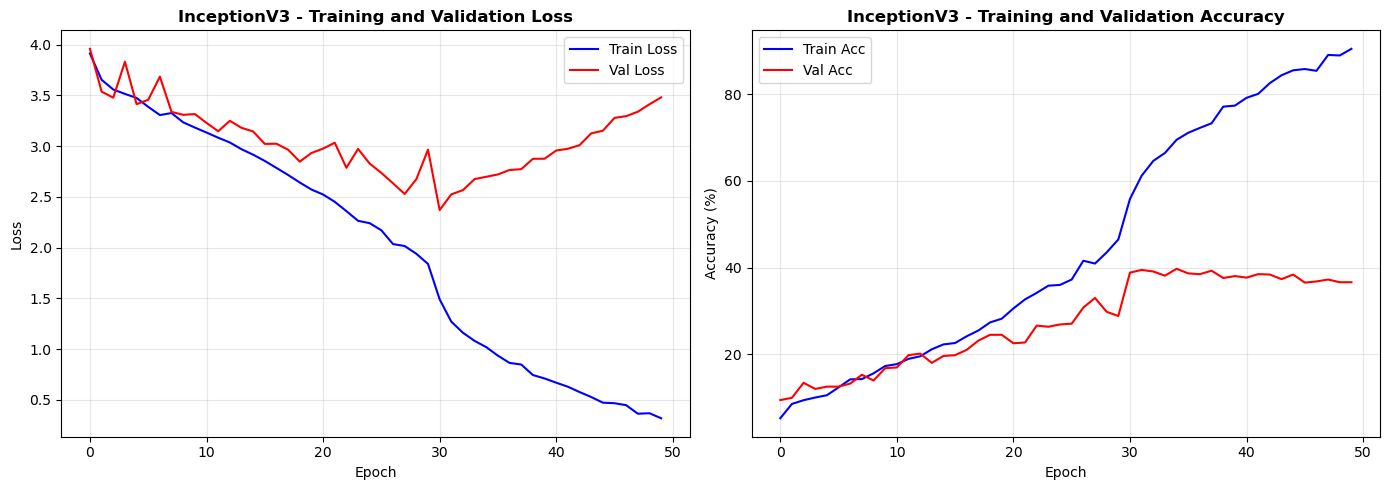


Training completed! Best validation accuracy: 39.72%

InceptionV3 Training Summary:
  Best Validation Accuracy: 39.72%
  Model saved: ./results/InceptionV3_best_model.pth


In [4]:

print("\n" + "="*60)
print("Training InceptionV3 Model")
print("="*60)
InceptionV3_model = create_model( num_classes)
InceptionV3_trained, InceptionV3_val_acc = train_model(
    InceptionV3_model, train_loader, val_loader, 
    num_epochs, learning_rate, 'InceptionV3', save_dir=results_dir
)

print(f"\nInceptionV3 Training Summary:")
print(f"  Best Validation Accuracy: {InceptionV3_val_acc:.2f}%")
print(f"  Model saved: {results_dir}/InceptionV3_best_model.pth")


## 4. Model Evaluation

Evaluate the best model on the test set with comprehensive metrics.


In [10]:
def evaluate_model(model, test_loader, class_names, model_name, save_dir='./results'):
    """
    Model Evaluation:
    - Accuracy, Precision, Recall, F1-score
    - Confusion Matrix
    """
    print("\n" + "="*60)
    print("4. MODEL EVALUATION")
    print("="*60)
    
    print("\n3(c) Model Evaluation on Test Set")
    print("-" * 40)
    
    print(f"\nEvaluating {model_name} on test set...")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    
    # Overall metrics (macro and weighted averages)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    
    print(f"\nTest Set Results:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"\n  Macro-Averaged Metrics:")
    print(f"    Precision: {macro_precision:.4f}")
    print(f"    Recall: {macro_recall:.4f}")
    print(f"    F1-Score: {macro_f1:.4f}")
    print(f"\n  Weighted-Averaged Metrics:")
    print(f"    Precision: {weighted_precision:.4f}")
    print(f"    Recall: {weighted_recall:.4f}")
    print(f"    F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Test Set ({model_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print(f"\n  Saved confusion matrix: {save_dir}/confusion_matrix.png")
    plt.show()
    
    # Per-class metrics (top 10 and bottom 10)
    class_metrics = list(zip(class_names, precision, recall, f1, support))
    class_metrics.sort(key=lambda x: x[3], reverse=True)  # Sort by F1-score
    
    print(f"\n  Top 10 Classes by F1-Score:")
    print(f"  {'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("  " + "-"*70)
    for name, prec, rec, f1_score, supp in class_metrics[:10]:
        print(f"  {name:<25} {prec:<12.4f} {rec:<12.4f} {f1_score:<12.4f} {supp:<10}")
    
    print(f"\n  Bottom 10 Classes by F1-Score:")
    print(f"  {'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("  " + "-"*70)
    for name, prec, rec, f1_score, supp in class_metrics[-10:]:
        print(f"  {name:<25} {prec:<12.4f} {rec:<12.4f} {f1_score:<12.4f} {supp:<10}")
    
    # Save results to file
    with open(f'{save_dir}/evaluation_results.txt', 'w') as f:
        f.write("DTD Dataset Classification - Evaluation Results\n")
        f.write("="*60 + "\n\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Test Accuracy: {accuracy*100:.2f}%\n\n")
        f.write("Macro-Averaged Metrics:\n")
        f.write(f"  Precision: {macro_precision:.4f}\n")
        f.write(f"  Recall: {macro_recall:.4f}\n")
        f.write(f"  F1-Score: {macro_f1:.4f}\n\n")
        f.write("Weighted-Averaged Metrics:\n")
        f.write(f"  Precision: {weighted_precision:.4f}\n")
        f.write(f"  Recall: {weighted_recall:.4f}\n")
        f.write(f"  F1-Score: {weighted_f1:.4f}\n\n")
        f.write("\nPer-Class Metrics:\n")
        f.write(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}\n")
        f.write("-"*70 + "\n")
        for name, prec, rec, f1_score, supp in zip(class_names, precision, recall, f1, support):
            f.write(f"{name:<25} {prec:<12.4f} {rec:<12.4f} {f1_score:<12.4f} {supp:<10}\n")
    
    print(f"\n  Saved detailed results: {save_dir}/evaluation_results.txt")
    print("\nEvaluation completed!")

print("Evaluation function defined!")


Evaluation function defined!



4. MODEL EVALUATION

3(c) Model Evaluation on Test Set
----------------------------------------

Evaluating InceptionV3 on test set...


Testing: 100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Test Set Results:
  Accuracy: 36.79%

  Macro-Averaged Metrics:
    Precision: 0.4022
    Recall: 0.3739
    F1-Score: 0.3736

  Weighted-Averaged Metrics:
    Precision: 0.4032
    Recall: 0.3679
    F1-Score: 0.3710

  Saved confusion matrix: ./results/confusion_matrix.png


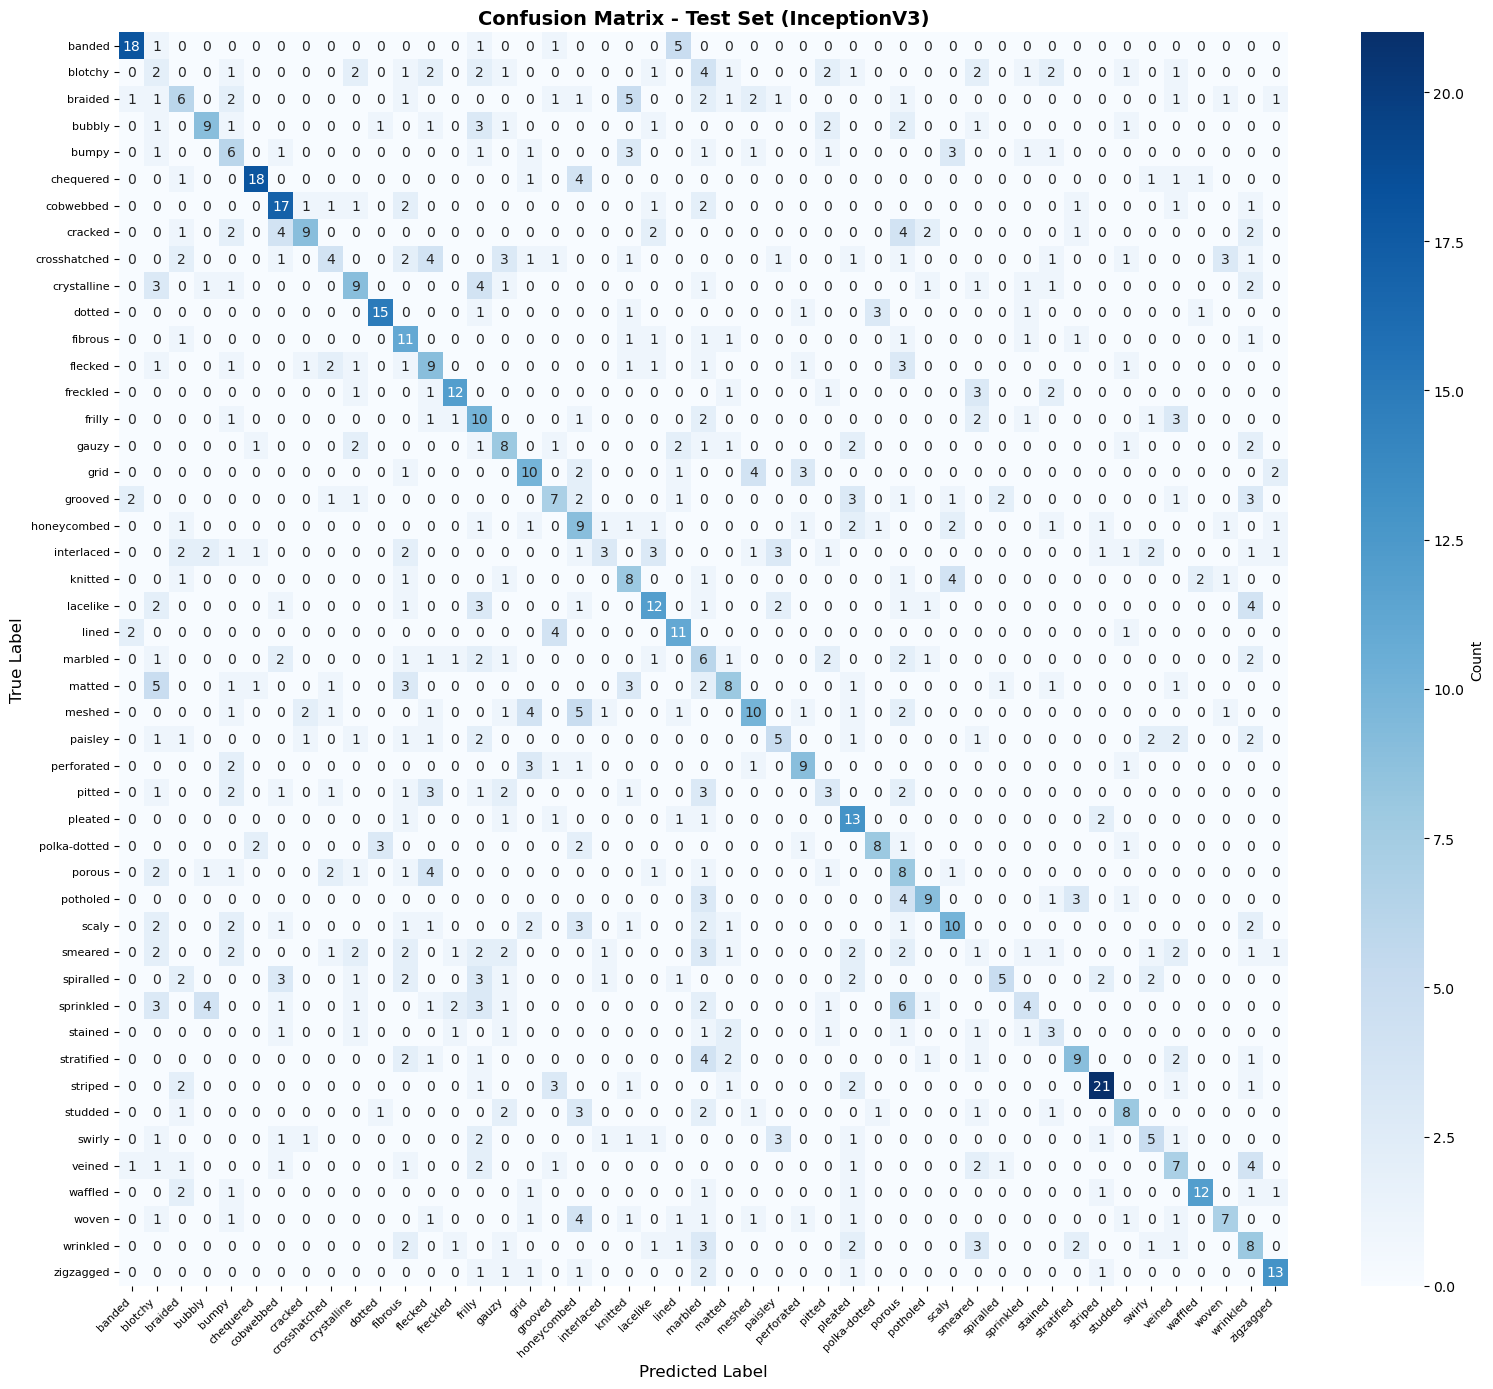


  Top 10 Classes by F1-Score:
  Class                     Precision    Recall       F1-Score     Support   
  ----------------------------------------------------------------------
  banded                    0.7500       0.6923       0.7200       26        
  chequered                 0.7826       0.6667       0.7200       27        
  dotted                    0.7500       0.6522       0.6977       23        
  striped                   0.7000       0.6364       0.6667       33        
  waffled                   0.7500       0.5714       0.6486       21        
  zigzagged                 0.6500       0.6190       0.6341       21        
  freckled                  0.6316       0.5714       0.6000       21        
  cobwebbed                 0.4857       0.6071       0.5397       28        
  polka-dotted              0.6154       0.4444       0.5161       18        
  lined                     0.4400       0.6111       0.5116       18        

  Bottom 10 Classes by F1-Score:
  Cl

In [11]:
# Evaluate the trained model
evaluate_model(InceptionV3_trained, test_loader, class_names, "InceptionV3", results_dir)
